# Simulación de un Sistema de Procesamiento con CPU y Terminales 🖥️📊

Este proyecto simula un sistema computacional donde varios terminales alternan entre **pensar** y **enviar trabajos** a una CPU que procesa los trabajos utilizando **planificación round-robin** con un **quantum de tiempo**. El objetivo es analizar métricas clave como el **tiempo de respuesta**, **tiempo en cola**, **utilización de la CPU**, y la **longitud de la cola** bajo diferentes cargas de trabajo.

---

In [1]:
import simpy
import random
import numpy as np
import matplotlib.pyplot as plt

## Constantes Definidas en la Simulación ⚙️

Las constantes en la simulación juegan un papel crucial para modelar el comportamiento del sistema. A continuación se explica el significado y la importancia de cada una de ellas:

---

### **THINKING_MEAN** 🧠

Esta constante representa el **tiempo medio** que un terminal pasa **pensando** antes de enviar un nuevo trabajo a la CPU. El valor está basado en una distribución exponencial con una media de **25 segundos**.

- **Importancia**: Modela el tiempo que cada terminal está "ocioso" entre trabajos, imitando cómo una persona o proceso podría pensar o prepararse antes de enviar una nueva solicitud al sistema.

---

### **SERVICE_MEAN** ⏳

Indica el **tiempo medio de servicio** de un trabajo. Este valor también sigue una distribución exponencial con una media de **0.8 segundos**.

- **Importancia**: Refleja cuánto tiempo en promedio toma la CPU para procesar un trabajo. Este valor impacta directamente en la carga que se le impone a la CPU y en los tiempos de respuesta del sistema.

---

### **QUANTUM** 🔄

El **quantum** es el período de tiempo durante el cual la CPU puede procesar un trabajo antes de cambiar a otro, si es necesario. En este caso, el quantum es de **0.1 segundos**.

- **Importancia**: Define cómo funciona la planificación **round-robin** en la CPU. Si un trabajo no se completa dentro de este tiempo, vuelve a la cola y deberá esperar su turno para recibir más tiempo de procesamiento.

---

### **CONTEXT_SWITCH** 🔁

Este valor representa el **tiempo de cambio de contexto**. Cada vez que la CPU cambia entre trabajos, se añade un costo de **0.015 segundos** debido al tiempo que toma cambiar entre tareas.

- **Importancia**: Simula el costo real que tiene cambiar de un proceso a otro en sistemas computacionales. Si hay demasiados cambios de contexto, esto puede afectar negativamente el rendimiento general del sistema.

---

### **TOTAL_JOBS** 📈

El **número total de trabajos** que el sistema procesará antes de finalizar la simulación es de **1000 trabajos**.

- **Importancia**: Define el límite del experimento. La simulación se detiene una vez que se han procesado todos los trabajos, permitiendo la recolección de métricas para ese conjunto específico de datos.

---

Estas constantes controlan la dinámica del sistema y afectan cómo se distribuyen las cargas de trabajo, el rendimiento de la CPU y los tiempos de respuesta y espera en cola.

In [2]:
THINKING_MEAN = 25
SERVICE_MEAN = 0.8
QUANTUM = 0.1
CONTEXT_SWITCH = 0.015
TOTAL_JOBS = 1000

## Clase **Terminal** 💻

La clase `Terminal` representa a un **terminal** que genera trabajos y los envía a la **CPU** para ser procesados. Cada terminal alterna entre pensar y generar nuevos trabajos.

### Atributos:
- **`env`**: El entorno de simulación (`simpy.Environment`), que controla el paso del tiempo.
- **`cpu`**: Referencia a la instancia de la clase `CPU` que procesará los trabajos.
- **`results`**: Lista donde se registran los tiempos de respuesta de los trabajos.
- **`wait_times`**: Lista donde se almacenan los tiempos de espera en la cola de la CPU.

### Funcionamiento:
- **Pensar**: Cada terminal pasa un tiempo **pensando** antes de enviar un trabajo a la CPU. Este tiempo sigue una distribución exponencial con una media de 25 segundos.
- **Enviar trabajos**: Después de pensar, el terminal genera un trabajo con un **tiempo de servicio** basado en una distribución exponencial (media de 0.8 segundos) y lo envía a la CPU.
- **Métricas registradas**: Se mide el **tiempo de espera** en la cola y el **tiempo de respuesta** total (desde la creación hasta la finalización del trabajo).

> _Cada terminal puede generar múltiples trabajos hasta que el sistema haya procesado **1000 trabajos** en total._

---


In [3]:
def exponential(mean):
    return random.expovariate(1.0 / mean)

class Terminal:
    def __init__(self, env, cpu, results, wait_times):
        self.env = env
        self.cpu = cpu
        self.results = results
        self.wait_times = wait_times
        self.thinking_time = exponential(THINKING_MEAN)
        self.process = env.process(self.run())
        
    def run(self):
        while len(self.results) < TOTAL_JOBS:
            yield self.env.timeout(self.thinking_time)
            
            service_time = exponential(SERVICE_MEAN)
            arrival_time = self.env.now
            
            start_wait = self.env.now
            yield self.env.process(self.cpu.process_job(service_time))
            wait_time = self.env.now - start_wait
            
            response_time = self.env.now - arrival_time
            self.results.append(response_time)
            self.wait_times.append(wait_time)
            
            self.thinking_time = exponential(THINKING_MEAN)



## Clase **CPU** 🖥️

La clase `CPU` es responsable de procesar los trabajos enviados por los terminales. Usa un esquema de **planificación round-robin** con un **quantum de servicio** y un **tiempo de cambio de contexto**.

### Atributos:
- **`env`**: El entorno de simulación, similar al de los terminales.
- **`queue`**: Cola (`simpy.Store`) donde se almacenan los trabajos que esperan ser procesados.
- **`working`**: Bandera que indica si la CPU está actualmente procesando un trabajo.
- **`busy_time`**: Tiempo total durante el cual la CPU estuvo **ocupada** procesando trabajos.
- **`queue_lengths`**: Lista que almacena la longitud de la cola cada vez que se procesa un trabajo.

### Funcionamiento:
- **Procesar trabajos**: La CPU extrae los trabajos de su cola y los procesa en intervalos de tiempo de **quantum**. Si un trabajo necesita más tiempo, vuelve a colocarse en la cola hasta que se complete.
- **Cambios de contexto**: Después de procesar cada trabajo, hay un **costo de cambio de contexto** de 0.015 segundos que se agrega al tiempo de procesamiento.
- **Registrar métricas**: La CPU registra la **utilización** (tiempo ocupado versus tiempo total) y la **longitud de la cola** durante la simulación.

> _La CPU trabaja en un ciclo continuo, sacando trabajos de la cola y procesándolos hasta que no quedan más trabajos._

---

In [4]:
class CPU:
    def __init__(self, env):
        self.env = env
        self.queue = simpy.Store(env)
        self.working = False
        self.busy_time = 0  # Tiempo total de CPU ocupada
        self.queue_lengths = []  # Registrar longitudes de cola
        
    def process_job(self, service_time):
        arrival_time = self.env.now
        yield self.queue.put(service_time)
        if not self.working:
            self.working = True
            yield self.env.process(self.start_processing())
            
    def start_processing(self):
        while len(self.queue.items) > 0:
            remaining_time = yield self.queue.get()
            
            while remaining_time > 0:
                quantum_time = min(remaining_time, QUANTUM)
                yield self.env.timeout(quantum_time + CONTEXT_SWITCH)
                self.busy_time += quantum_time + CONTEXT_SWITCH
                remaining_time -= quantum_time
                
            self.queue_lengths.append(len(self.queue.items))
        self.working = False

## Proceso de Simulación 🔄

La simulación se ejecuta para diferentes cantidades de terminales (5, 10, 20, 40, 80) y se registran las siguientes **métricas clave**:

1. **Tiempo medio de respuesta**: Promedio del tiempo que tardan los trabajos desde que son generados hasta que son procesados completamente.
2. **Tiempo medio de espera en cola**: Promedio del tiempo que los trabajos pasan en la cola antes de ser procesados por la CPU.
3. **Utilización de la CPU**: Porcentaje del tiempo total de simulación durante el cual la CPU estuvo ocupada procesando trabajos.
4. **Longitud media de la cola**: Número promedio de trabajos esperando en la cola de la CPU.

---

In [5]:
def simulate_system(n_terminals):
    env = simpy.Environment()
    cpu = CPU(env)
    results = []
    wait_times = []
    
    for _ in range(n_terminals):
        Terminal(env, cpu, results, wait_times)
    
    env.run()
    
    mean_response_time = np.mean(results)
    mean_wait_time = np.mean(wait_times)
    cpu_utilization = cpu.busy_time / env.now
    mean_queue_length = np.mean(cpu.queue_lengths)
    
    return mean_response_time, mean_wait_time, cpu_utilization, mean_queue_length

## Métricas e **Insights** 📈

### **Tiempo de respuesta y número de terminales**:
A medida que aumenta el número de terminales, el **tiempo de respuesta** tiende a aumentar. Esto es porque más terminales generan más trabajos, aumentando la carga en la CPU.

### **Tiempo de espera en cola**:
Si el **tiempo medio de espera en cola** aumenta significativamente con el número de terminales, es una señal de que la **CPU está saturada** y no puede procesar los trabajos con suficiente rapidez.

### **Utilización de la CPU**:
La **utilización de la CPU** debe aumentar con el número de terminales. Sin embargo, si la utilización se acerca al **100%**, el sistema está **sobrecargado**, lo que podría causar mayores tiempos de espera y de respuesta.

### **Longitud de la cola**:
El **número de trabajos en cola** aumenta cuando la CPU no puede seguir el ritmo de las solicitudes entrantes. Un aumento grande en la longitud de la cola indica que el sistema necesita más capacidad de procesamiento para evitar cuellos de botella.

---


In [6]:
# Almacenar métricas
response_times = []
wait_times = []
cpu_utilizations = []
queue_lengths = []
terminal_counts = [5, 10, 20, 40, 80]

## Visualización de Resultados 📊

Se grafican los resultados de las simulaciones para diferentes números de terminales, mostrando:

- **Tiempo medio de respuesta** vs **Número de terminales**.
- **Tiempo medio de espera en cola** vs **Número de terminales**.
- **Utilización de la CPU** vs **Número de terminales**.
- **Longitud media de la cola** vs **Número de terminales**.

Estos gráficos ayudan a visualizar el rendimiento del sistema bajo distintas cargas y a determinar cuántos terminales permiten un **tiempo de respuesta óptimo** sin sobrecargar la CPU.

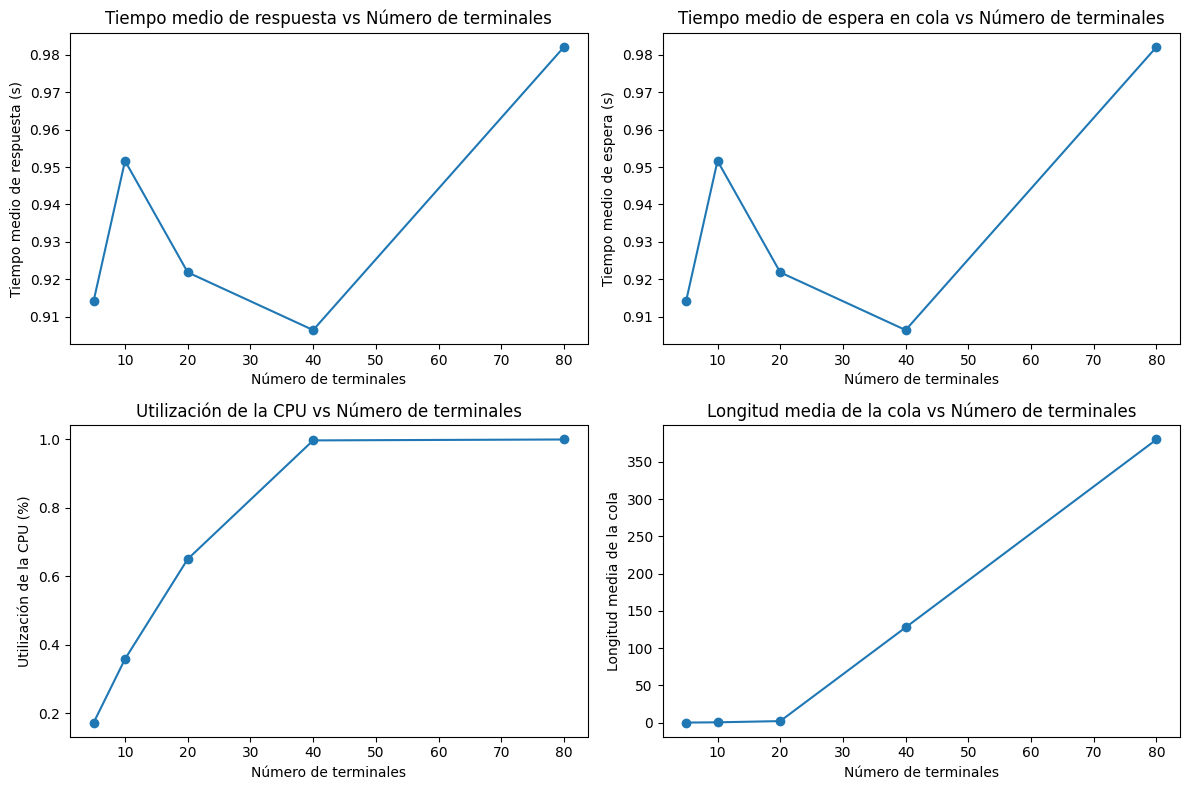

In [7]:

# Ejecutar simulaciones
for n in terminal_counts:
    mean_response_time, mean_wait_time, cpu_utilization, mean_queue_length = simulate_system(n)
    response_times.append(mean_response_time)
    wait_times.append(mean_wait_time)
    cpu_utilizations.append(cpu_utilization)
    queue_lengths.append(mean_queue_length)

# Graficar resultados
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(terminal_counts, response_times, marker='o')
plt.title('Tiempo medio de respuesta vs Número de terminales')
plt.xlabel('Número de terminales')
plt.ylabel('Tiempo medio de respuesta (s)')

plt.subplot(2, 2, 2)
plt.plot(terminal_counts, wait_times, marker='o')
plt.title('Tiempo medio de espera en cola vs Número de terminales')
plt.xlabel('Número de terminales')
plt.ylabel('Tiempo medio de espera (s)')

plt.subplot(2, 2, 3)
plt.plot(terminal_counts, cpu_utilizations, marker='o')
plt.title('Utilización de la CPU vs Número de terminales')
plt.xlabel('Número de terminales')
plt.ylabel('Utilización de la CPU (%)')

plt.subplot(2, 2, 4)
plt.plot(terminal_counts, queue_lengths, marker='o')
plt.title('Longitud media de la cola vs Número de terminales')
plt.xlabel('Número de terminales')
plt.ylabel('Longitud media de la cola')

plt.tight_layout()
plt.show()